In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [3]:
mat = scipy.io.loadmat('notMNIST_small.mat')
mat.keys()


dict_keys(['__header__', '__version__', '__globals__', 'images', 'labels'])

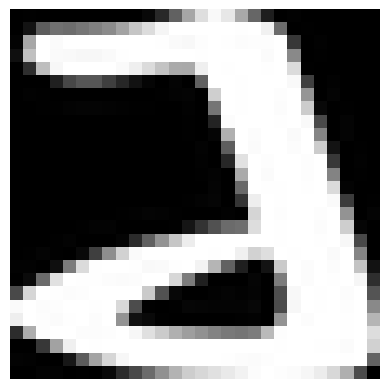

In [4]:
mat['images'].shape

plt.imshow(mat['images'][:, :, 1], cmap='gray')
plt.axis('off')
plt.show()

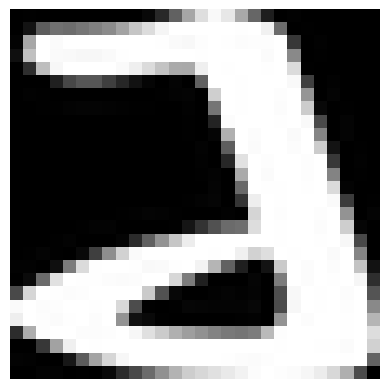

(18724, 28, 28)

In [5]:
new_img = np.random.rand(18724, 28, 28)
for index in range(mat['images'].shape[2]):
    new_img[index] = mat['images'][:,:,index]

plt.imshow(new_img[1, :, :], cmap='gray')
plt.axis('off')
plt.show()

new_img.shape

In [6]:
indices = np.arange(18724)
np.random.shuffle(indices)
labels = np.array(mat['labels'])


shuffled_images = new_img[indices]
shuffled_labels = labels[indices]

In [7]:
x_train_img = np.array(shuffled_images[0:11234, :,:])
x_test_img = np.array(shuffled_images[11235:18724, :,:])
y_train_label = np.array(shuffled_labels[0:11234])
y_test_label =np.array(shuffled_labels[11235:18724])

x_train_img.shape

(11234, 28, 28)

In [8]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):

        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

    
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [9]:
test_images = x_test_img
test_labels = y_test_label

test_dataset = CustomDataset(test_images, test_labels)

test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [10]:
from torch.utils.data import DataLoader


images = x_train_img
labels = y_train_label

custom_dataset = CustomDataset(images, labels)


data_loader = DataLoader(dataset=custom_dataset, batch_size=32, shuffle=True)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):  
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  #(28/2/2 = 7)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = x2.view(-1, 64 * 7 * 7)
        x4 = F.relu(self.fc1(x3))
        out = self.fc2(x4)
        return x1, x2, x3, x4, out

In [12]:
model = SimpleCNN(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

model = model.to(device)

num_epochs = 20  

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        _, _, _, _, outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')

        del images, labels, outputs, loss
        torch.cuda.empty_cache()


C:\Users\denis\AppData\Local\Temp\ipykernel_12228\3105449872.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1/20, Step 100/352, Loss: 0.58026
Epoch 1/20, Step 200/352, Loss: 0.43521
Epoch 1/20, Step 300/352, Loss: 0.27999
Epoch 2/20, Step 100/352, Loss: 0.08980
Epoch 2/20, Step 200/352, Loss: 0.66964
Epoch 2/20, Step 300/352, Loss: 0.42784
Epoch 3/20, Step 100/352, Loss: 0.20725
Epoch 3/20, Step 200/352, Loss: 0.21175
Epoch 3/20, Step 300/352, Loss: 0.11478
Epoch 4/20, Step 100/352, Loss: 0.01227
Epoch 4/20, Step 200/352, Loss: 0.26010
Epoch 4/20, Step 300/352, Loss: 0.04709
Epoch 5/20, Step 100/352, Loss: 0.01664
Epoch 5/20, Step 200/352, Loss: 0.16483
Epoch 5/20, Step 300/352, Loss: 0.10968
Epoch 6/20, Step 100/352, Loss: 0.09271
Epoch 6/20, Step 200/352, Loss: 0.06499
Epoch 6/20, Step 300/352, Loss: 0.12475
Epoch 7/20, Step 100/352, Loss: 0.04016
Epoch 7/20, Step 200/352, Loss: 0.00576
Epoch 7/20, Step 300/352, Loss: 0.07734
Epoch 8/20, Step 100/352, Loss: 0.08601
Epoch 8/20, Step 200/352, Loss: 0.05777
Epoch 8/20, Step 300/352, Loss: 0.04588
Epoch 9/20, Step 100/352, Loss: 0.00149


In [13]:
def test_model(model, test_loader):
    model = model.to(device)
    model.eval() 
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)  
        _, _, _, _,outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


test_model(model, test_loader)

C:\Users\denis\AppData\Local\Temp\ipykernel_12228\3105449872.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 92.87%


C:\Users\denis\AppData\Local\Temp\ipykernel_12228\3105449872.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1/25, Step 100/352, Loss: 0.36709
Epoch 1/25, Step 200/352, Loss: 0.83000
Epoch 1/25, Step 300/352, Loss: 0.06066
Epoch 2/25, Step 100/352, Loss: 0.24371
Epoch 2/25, Step 200/352, Loss: 0.32701
Epoch 2/25, Step 300/352, Loss: 0.17129
Epoch 3/25, Step 100/352, Loss: 0.06460
Epoch 3/25, Step 200/352, Loss: 0.32763
Epoch 3/25, Step 300/352, Loss: 0.07855
Epoch 4/25, Step 100/352, Loss: 0.08659
Epoch 4/25, Step 200/352, Loss: 0.26692
Epoch 4/25, Step 300/352, Loss: 0.06652
Epoch 5/25, Step 100/352, Loss: 0.10634
Epoch 5/25, Step 200/352, Loss: 0.03598
Epoch 5/25, Step 300/352, Loss: 0.04357
Epoch 6/25, Step 100/352, Loss: 0.00328
Epoch 6/25, Step 200/352, Loss: 0.09134
Epoch 6/25, Step 300/352, Loss: 0.01099
Epoch 7/25, Step 100/352, Loss: 0.00077
Epoch 7/25, Step 200/352, Loss: 0.00315
Epoch 7/25, Step 300/352, Loss: 0.14069
Epoch 8/25, Step 100/352, Loss: 0.00294
Epoch 8/25, Step 200/352, Loss: 0.10849
Epoch 8/25, Step 300/352, Loss: 0.00905
Epoch 9/25, Step 100/352, Loss: 0.00153


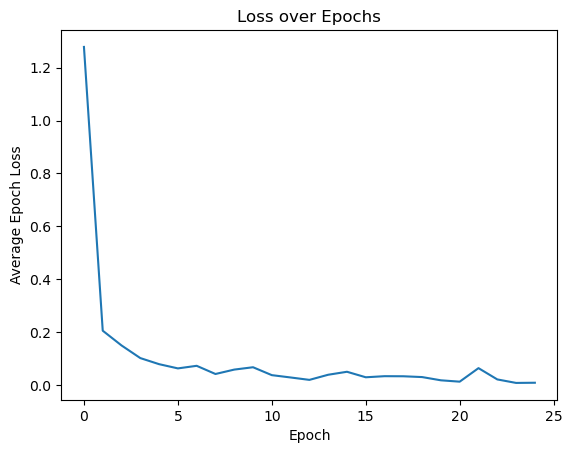

In [14]:
model_2 = SimpleCNN(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001) 

model_2 = model_2.to(device)

num_epochs = 25  
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0  
    num_batches = 0 

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        _, _, _, _, outputs = model_2(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')

        del images, labels, outputs, loss
        torch.cuda.empty_cache()

    epoch_loss /= num_batches
    epoch_losses.append(epoch_loss)

plt.plot(epoch_losses)
plt.ylabel('Average Epoch Loss')
plt.xlabel('Epoch')
plt.title('Loss over Epochs')
plt.show()


In [17]:
def test_model_2(model_2, test_loader):
    model_2 = model_2.to(device)
    
    model_2.eval() 
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        images = images.unsqueeze(1)  
        _, _, _, _,outputs = model_2(images)
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    del images, labels, outputs
    torch.cuda.empty_cache()

test_model_2(model_2, test_loader)


C:\Users\denis\AppData\Local\Temp\ipykernel_12228\3105449872.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 93.12%


In [18]:

class SimpleCNN_x(nn.Module):
    def __init__(self, num_classes=10):  
        super(SimpleCNN_x, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(3136, 128)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.pool(F.relu(self.conv3(x2)))
        x3 = x3.view(x3.size(0), -1)  
        x4 = F.relu(self.fc1(x3))
        out = self.fc2(x4)
        return x1, x2, x3, out


C:\Users\denis\AppData\Local\Temp\ipykernel_12228\3105449872.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1/25, Step 100/352, Loss: 0.44400
Epoch 1/25, Step 200/352, Loss: 0.31059
Epoch 1/25, Step 300/352, Loss: 0.29747
Epoch 2/25, Step 100/352, Loss: 0.14826
Epoch 2/25, Step 200/352, Loss: 0.33098
Epoch 2/25, Step 300/352, Loss: 0.34438
Epoch 3/25, Step 100/352, Loss: 0.03341
Epoch 3/25, Step 200/352, Loss: 0.27392
Epoch 3/25, Step 300/352, Loss: 0.29789
Epoch 4/25, Step 100/352, Loss: 0.02810
Epoch 4/25, Step 200/352, Loss: 0.11986
Epoch 4/25, Step 300/352, Loss: 0.03831
Epoch 5/25, Step 100/352, Loss: 0.02598
Epoch 5/25, Step 200/352, Loss: 0.03618
Epoch 5/25, Step 300/352, Loss: 0.12564
Epoch 6/25, Step 100/352, Loss: 0.05625
Epoch 6/25, Step 200/352, Loss: 0.03074
Epoch 6/25, Step 300/352, Loss: 0.12624
Epoch 7/25, Step 100/352, Loss: 0.02610
Epoch 7/25, Step 200/352, Loss: 0.10771
Epoch 7/25, Step 300/352, Loss: 0.22709
Epoch 8/25, Step 100/352, Loss: 0.00983
Epoch 8/25, Step 200/352, Loss: 0.04809
Epoch 8/25, Step 300/352, Loss: 0.01666
Epoch 9/25, Step 100/352, Loss: 0.05280


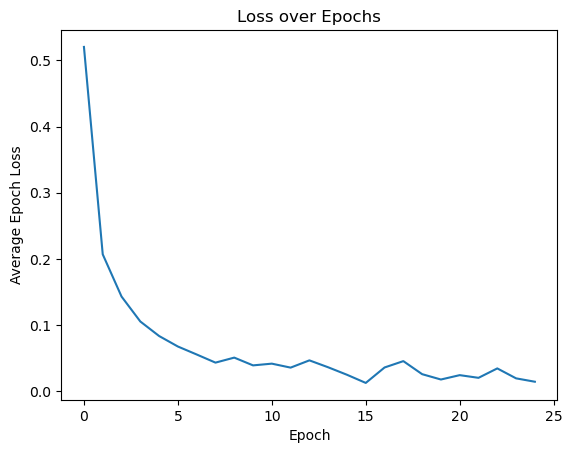

In [19]:
mdlx = SimpleCNN_x(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(mdlx.parameters(), lr=0.001) 

mdlx = mdlx.to(device)

num_epochs = 25  
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0 
    num_batches = 0  

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        _, _, _, outputs = mdlx(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')

        del images, labels, outputs, loss
        torch.cuda.empty_cache()

    epoch_loss /= num_batches
    epoch_losses.append(epoch_loss)

plt.plot(epoch_losses)
plt.ylabel('Average Epoch Loss')
plt.xlabel('Epoch')
plt.title('Loss over Epochs')
plt.show()


In [20]:
def test_model_x(mdlx, test_loader):
    mdlx = mdlx.to(device)
    
    mdlx.eval() 
    correct = 0
    total = 0
     
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        images = images.unsqueeze(1)  
        _, _, _, outputs = mdlx(images)
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    del images, labels, outputs
    torch.cuda.empty_cache()

test_model_x(mdlx, test_loader)


C:\Users\denis\AppData\Local\Temp\ipykernel_12228\3105449872.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 93.96%


In [21]:

class SimpleCNN_2(nn.Module):
    def __init__(self, num_classes=10):  
        super(SimpleCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(128 * 7 * 7, 128)  # updating dimensions
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))  
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))  
        x = x.view(-1, 128 * 7 * 7)  # updating the flattening
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out


C:\Users\denis\AppData\Local\Temp\ipykernel_12228\3105449872.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)
c:\Users\denis\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/50, Step 100/352, Loss: 1.16440
Epoch 1/50, Step 200/352, Loss: 0.60363
Epoch 1/50, Step 300/352, Loss: 0.39017
Epoch 2/50, Step 100/352, Loss: 0.58831
Epoch 2/50, Step 200/352, Loss: 0.63405
Epoch 2/50, Step 300/352, Loss: 0.61301
Epoch 3/50, Step 100/352, Loss: 0.09509
Epoch 3/50, Step 200/352, Loss: 0.14827
Epoch 3/50, Step 300/352, Loss: 0.29306
Epoch 4/50, Step 100/352, Loss: 0.05624
Epoch 4/50, Step 200/352, Loss: 0.36541
Epoch 4/50, Step 300/352, Loss: 0.20348
Epoch 5/50, Step 100/352, Loss: 0.10937
Epoch 5/50, Step 200/352, Loss: 0.13203
Epoch 5/50, Step 300/352, Loss: 0.09360
Epoch 6/50, Step 100/352, Loss: 0.05413
Epoch 6/50, Step 200/352, Loss: 0.11674
Epoch 6/50, Step 300/352, Loss: 0.30172
Epoch 7/50, Step 100/352, Loss: 0.39516
Epoch 7/50, Step 200/352, Loss: 0.20746
Epoch 7/50, Step 300/352, Loss: 0.33985
Epoch 8/50, Step 100/352, Loss: 0.08669
Epoch 8/50, Step 200/352, Loss: 0.08938
Epoch 8/50, Step 300/352, Loss: 0.26887
Epoch 9/50, Step 100/352, Loss: 0.12250


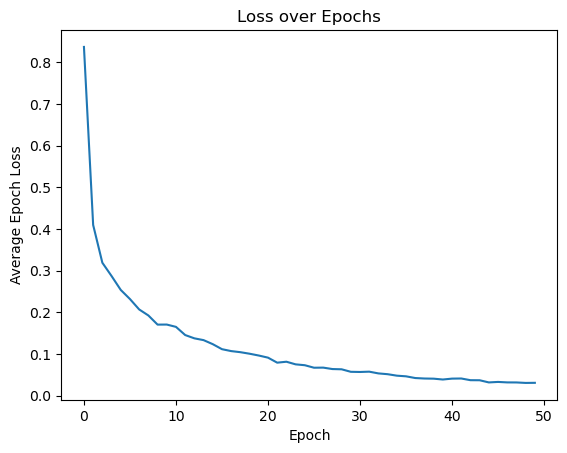

In [22]:
model_x = SimpleCNN_2(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model_x.parameters(), lr=0.001, momentum=0.1)

model_x = model_x.to(device)

num_epochs = 50
epoch_losses  = []

for epoch in range(num_epochs):
    epoch_loss = 0  
    num_batches = 0  

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        outputs = model_x(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')

        del images, labels, outputs, loss
        torch.cuda.empty_cache()

    epoch_loss /= num_batches
    epoch_losses.append(epoch_loss)
            
plt.plot(epoch_losses)
plt.ylabel('Average Epoch Loss')
plt.xlabel('Epoch')
plt.title('Loss over Epochs')
plt.show()

In [23]:
def test_model_x(model_x, test_loader):
    model_x = model_x.to(device)
    
    model_x.eval() 
    correct = 0
    total = 0
     
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        images = images.unsqueeze(1)  
        outputs = model_x(images)
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    del images, labels, outputs
    torch.cuda.empty_cache()

test_model_x(model_x, test_loader)


C:\Users\denis\AppData\Local\Temp\ipykernel_12228\3105449872.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 94.14%
